# Initial setting

## libraries

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css"
).text
HTML(styles)

In [2]:
import re
import requests
from time import sleep
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

from collections import OrderedDict

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

## dataset

In [3]:
# Load data
df = pd.read_csv('data/df_fifa.csv')

In [4]:
df.shape

(100995, 146)

In [5]:
df.head()

,sofifa_id,short_name,age,dob,height_cm,weight_kg,nationality,club,overall,value_eur,wage_eur,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,release_clause_eur,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,year,league_name,d_trait_Cautious_With_Crosses,d_trait_Injury_Prone,d_trait_Avoids_Using_Weaker_Foot,d_trait_Backs_Into_Player,d_trait_Flair,d_trait_Saves_with_Feet,d_trait_Leadership,d_trait_Inflexible,d_trait_Finesse_Shot,d_trait_Team_Player,d_trait_1-on-1_Rush,d_trait_Set_Play_Specialist,d_trait_Rushes_Out_Of_Goal,d_trait_Beat_Offside_Trap,d_trait_Early_Crosser,d_trait_Second_Wind,d_trait_Through_Ball,d_trait_Long_Throw-in,d_trait_Giant_Throw-in,d_trait_Diver,d_trait_Acrobatic_Clearance,d_trait_Selfish,d_trait_GK_Up_for_Corners,d_trait_Argues_with_Officials,d_trait_Takes_Finesse_Free_Kicks,...,d_pos_GK,ab_pace,ab_shooting,ab_passing,ab_dribbling,ab_defending,ab_physic,ab_skill_moves,ab_gk_diving,ab_gk_handling,ab_gk_kicking,ab_gk_reflexes,ab_gk_speed,ab_gk_positioning,ab_attacking_crossing,ab_attacking_finishing,ab_attacking_heading_accuracy,ab_attacking_short_passing,ab_attacking_volleys,ab_skill_dribbling,ab_skill_curve,ab_skill_fk_accuracy,ab_skill_long_passing,ab_skill_ball_control,ab_movement_acceleration,ab_movement_sprint_speed,ab_movement_agility,ab_movement_reactions,ab_movement_balance,ab_power_shot_power,ab_power_jumping,ab_power_stamina,ab_power_strength,ab_power_long_shots,ab_mentality_aggression,ab_mentality_interceptions,ab_mentality_positioning,ab_mentality_vision,ab_mentality_penalties,ab_mentality_composure,ab_defending_marking,ab_defending_standing_tackle,ab_defending_sliding_tackle,ab_goalkeeping_diving,ab_goalkeeping_handling,ab_goalkeeping_kicking,ab_goalkeeping_positioning,ab_goalkeeping_reflexes,d_foot_left,d_div1_league
0,158023,L. Messi,27,1987-06-24,169,67,Argentina,FC Barcelona,93,0,0,Left,5,3,4,Medium/Low,Normal,NaN,CF,10.0,NaN,2004-07-01,2018.0,2015,Spain Primera Division,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,93.0,89.0,86.0,96.0,27.0,63.0,4,NaN,NaN,NaN,NaN,NaN,NaN,84,94,71,89,85,96,89,90,76,96,96,90,94,94,95,80,73,77,60,88,48,22,92,90,76,NaN,25,21,20,6,11,15,14,8,1,1
1,20801,Cristiano Ronaldo,29,1985-02-05,185,80,Portugal,Real Madrid,92,0,0,Right,5,4,5,High/Low,Normal,NaN,LW,7.0,NaN,2009-07-01,2018.0,2015,Spain Primera Division,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,93.0,93.0,81.0,91.0,32.0,79.0,5,NaN,NaN,NaN,NaN,NaN,NaN,83,95,86,82,87,93,88,79,72,92,91,94,93,90,63,94,94,89,79,93,63,24,91,81,85,NaN,22,31,23,7,11,15,14,11,0,1
2,9014,A. Robben,30,1984-01-23,180,80,Netherlands,FC Bayern München,90,0,0,Left,5,2,4,High/Low,Normal,NaN,SUB,10.0,NaN,2009-08-28,2017.0,2015,German 1. Bundesliga,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,...,0,93.0,86.0,83.0,92.0,32.0,64.0,4,NaN,NaN,NaN,NaN,NaN,NaN,80,85,50,86,86,93,85,83,76,90,93,93,93,89,91,86,61,78,65,90,47,39,89,84,80,NaN,29,26,26,10,8,11,5,15,1,1
3,41236,Z. Ibrahimović,32,1981-10-03,195,95,Sweden,Paris Saint-Germain,90,0,0,Right,5,4,4,Medium/Low,Normal,NaN,ST,10.0,NaN,2012-07-01,2016.0,2015,French Ligue 1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,76.0,91.0,81.0,86.0,34.0,86.0,4,NaN,NaN,NaN,NaN,NaN,NaN,76,91,76,84,92,88,80,80,76,90,74,77,86,85,41,93,72,78,93,88,84,20,86,83,91,NaN,25,41,27,13,15,10,9,12,0,1
4,167495,M. Neuer,28,1986-03-27,193,92,Germany,FC Bayern München,90,0,0,Right,5,4,1,Medium/Medium,Normal,NaN,GK,1.0,NaN,2011-07-01,2019.0,2015,German 1. Bundesliga,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,1,87.0,85.0,92.0,86.0,60.0,90.0,25,25,25,42,25,25,25,25,41,31,58,61,43,89,35,42,78,44,83,25,29,30,25,20,37,NaN,25,25,25,87,85,92,90,86,0,1


To do
- merge overall 2020 & all predictors from 2019
- divide the dataset into train and test sets
- conduct PCA regression
- compute train and test MSE

# Data handling

## create the dataset for Part A

In [6]:
# filter 2020 overall score and sofifa_id
df_a_2020 = df[df['year'] == 2020][['sofifa_id','overall']]
df_a_2020.columns = ['sofifa_id','overall_2020']

# filter everything from 2019
df_a_2019 = df[df['year'] == 2019]
df_a_2019.columns = ['overall_2019' if x == 'overall' else x for x in df_a_2019.columns]

# merge them into a single dataset
df_a = pd.merge(df_a_2020, df_a_2019, on='sofifa_id')
df_a.shape

(13144, 147)

## drop columns, imputation, and train-test divide

In [7]:
# drop unnecessary columns
drop_vars = ['sofifa_id','short_name','dob','nationality','work_rate','body_type','team_position','loaned_from','overall_2019',
            'preferred_foot','joined','contract_valid_until','year','league_name','main_position','team_jersey_number']
df_a_all = df_a.drop(drop_vars, axis=1)

# drop rows that do not contain enough information in primary ability variables (e.g. ab_pace)
df_a_all = df_a_all[-df_a_all.ab_pace.isna()]
#df_a_all = df_a_all[df_a_all.d_div1_league == 1]

# impute zero values for release_clause and goalkeeping ability
# this is because goalkeeping ability is not available for field players
impute_vars = ['release_clause_eur'] + [x for x in df_a_all.columns if x.startswith('ab_gk')]
for var in impute_vars:
    df_a_all[var] = df_a_all[var].fillna(0)

# select players in the following clubs as test set
select_clubs = ['FC Barcelona','FC Bayern München','Real Madrid','Paris Saint-Germain','Juventus','Manchester City','Liverpool']
df_a_te = df_a_all[df_a_all.club.isin(select_clubs)].drop(['club'], axis=1)
df_a_tr = df_a_all[-df_a_all.club.isin(select_clubs)].drop(['club'], axis=1)
print(df_a_tr.shape, df_a_te.shape)

(11506, 130) (170, 130)


# Regression

In [23]:
list(df_a_tr.columns)

['overall_2020',
 'age',
 'height_cm',
 'weight_kg',
 'value_eur',
 'wage_eur',
 'international_reputation',
 'weak_foot',
 'skill_moves',
 'release_clause_eur',
 'd_trait_Cautious_With_Crosses',
 'd_trait_Injury_Prone',
 'd_trait_Avoids_Using_Weaker_Foot',
 'd_trait_Backs_Into_Player',
 'd_trait_Flair',
 'd_trait_Saves_with_Feet',
 'd_trait_Leadership',
 'd_trait_Inflexible',
 'd_trait_Finesse_Shot',
 'd_trait_Team_Player',
 'd_trait_1-on-1_Rush',
 'd_trait_Set_Play_Specialist',
 'd_trait_Rushes_Out_Of_Goal',
 'd_trait_Beat_Offside_Trap',
 'd_trait_Early_Crosser',
 'd_trait_Second_Wind',
 'd_trait_Through_Ball',
 'd_trait_Long_Throw-in',
 'd_trait_Giant_Throw-in',
 'd_trait_Diver',
 'd_trait_Acrobatic_Clearance',
 'd_trait_Selfish',
 'd_trait_GK_Up_for_Corners',
 'd_trait_Argues_with_Officials',
 'd_trait_Takes_Finesse_Free_Kicks',
 'd_trait_GK_Long_Throw',
 'd_trait_Swerve_Pass',
 'd_trait_Flair_Passes',
 'd_trait_One_Club_Player',
 'd_trait_Skilled_Dribbling',
 'd_trait_Outside_Foot

## PCA regression - test MSE too high! useless!

In [9]:
# set predictors and response variable
x_tr = df_a_tr.drop(['overall_2020'], axis=1).to_numpy()
y_tr = df_a_tr.overall_2020.to_numpy()
x_te = df_a_te.drop(['overall_2020'], axis=1).to_numpy()
y_te = df_a_te.overall_2020.to_numpy()

In [10]:
# standardization
scaler = StandardScaler().fit(x_tr)
x_tr_stan = scaler.transform(x_tr)
x_te_stan = scaler.transform(x_te)

# pca
pca_stan = PCA().fit(x_tr_stan)
x_tr_pca = pca_stan.transform(x_tr_stan)
x_te_pca = pca_stan.transform(x_te_stan)
print(f'Shape of train and test set: {x_tr_pca.shape}, {x_te_pca.shape}')

Shape of train and test set: (11506, 129), (170, 129)


In [14]:
# convert pca sets into dataframes
pca_columns = ['PCA' + str(x+1) for x in range(len(x_tr_pca[0]))]
df_tr_pca = pd.DataFrame(x_tr_pca, columns=pca_columns)
df_te_pca = pd.DataFrame(x_te_pca, columns=pca_columns)

df_y_tr = df_a_tr.overall_2020.reset_index()
df_y_te = df_a_te.overall_2020.reset_index()

df_tr_pca = pd.concat([df_y_tr, df_tr_pca], axis=1).drop(['index'], axis=1)
df_te_pca = pd.concat([df_y_te, df_te_pca], axis=1).drop(['index'], axis=1)

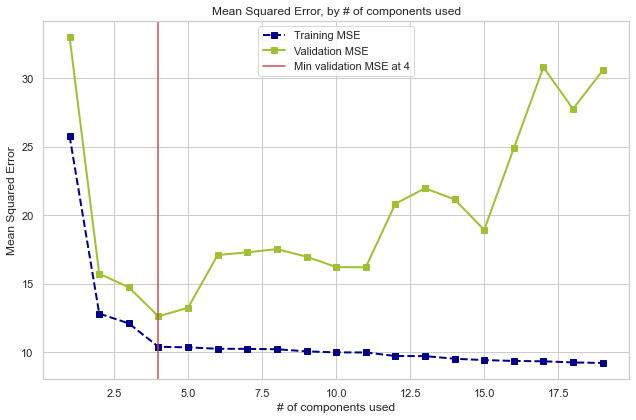

In [15]:
# create the list of components
comps = list(range(1,20))
tr_ac = []
val_ac = []

for comp in comps:
        
    # perform cross-validation on the training data with 10 folds and get the mse_scores
    pcr = LinearRegression()
    pcr_cv = cross_validate(pcr, df_tr_pca[pca_columns[0:comp]],df_tr_pca['overall_2020'],
                            cv=10, scoring='neg_mean_squared_error', return_train_score=True)

    # append accuracy for train set and validation set
    tr_ac.append(pcr_cv['train_score'].mean() * -1)
    val_ac.append(pcr_cv['test_score'].mean() * -1)

# determin the best parameter by validation score
best_comp = comps[val_ac.index(min(val_ac))]

# plotting
fig, ax = plt.subplots(1, 1, figsize = (9, 6))
ax.plot(comps,tr_ac,'s--', label = 'Training MSE',color = 'Darkblue',linewidth=2)
ax.plot(comps,val_ac,'s-', label = 'Validation MSE',color ='#9FC131FF',linewidth=2)
ax.axvline(best_comp, 0, 1, color = 'r', label = f'Min validation MSE at {best_comp}')
ax.set_xlabel('# of components used')
ax.set_ylabel('Mean Squared Error')
ax.legend(loc = 'best')
ax.set_title('Mean Squared Error, by # of components used')
plt.tight_layout()

In [17]:
# compute MSE for train & test set
pcr.fit(df_tr_pca[pca_columns[0:best_comp]],df_tr_pca['overall_2020'])
pcr_pred_tr = pcr.predict(df_tr_pca[pca_columns[0:best_comp]])
pcr_pred_te = pcr.predict(df_te_pca[pca_columns[0:best_comp]])

pcr_mse_tr = mean_squared_error(y_tr, pcr_pred_tr)
pcr_mse_te = mean_squared_error(y_te, pcr_pred_te)
print(pcr_mse_tr, pcr_mse_te)

10.506577587517434 77.4321398666859


## Lasso regression

In [18]:
# standardization
scaler = StandardScaler().fit(x_tr)
x_tr_stan = scaler.transform(x_tr)
x_te_stan = scaler.transform(x_te)

In [19]:
# set parameters
alphas = [1e-3, 1e-2, 1e-1, 1, 1e+1, 1e+2]

# create empty lists to store errors
tr_err, val_err = [],[]

# run regression for each alpha
for alpha in alphas:
    # standard scaler
    scaler = StandardScaler()
    x_tr_stan = scaler.fit_transform(x_tr)

    # perform cross-validation on the training data with 10 folds and get the mse_scores
    lasso = Lasso(alpha=alpha, max_iter=10000)
    scores = cross_validate(lasso, x_tr_stan, y_tr, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    
    #Compute the train and validation MSE
    tr_err.append(scores['train_score'].mean() * -1)
    val_err.append(scores['test_score'].mean() * -1)

# find the degree that returns the minimum validation error
min_val_err = min(val_err)
best_alpha = alphas[val_err.index(min_val_err)]

In [24]:
print(min_val_err, best_alpha)

13.135442647795731 0.1


In [25]:
lasso_best = Lasso(alpha=best_alpha, max_iter=10000)
lasso_best.fit(x_tr_stan, y_tr)

lasso_tr_pred = lasso_best.predict(x_tr_stan)
lasso_te_pred = lasso_best.predict(x_te_stan)

lasso_mse_tr = mean_squared_error(y_tr, lasso_tr_pred)
lasso_mse_te = mean_squared_error(y_te, lasso_te_pred)
print(lasso_mse_tr, lasso_mse_te)

7.591801420994809 17.889881518470872


## Random Forest regression (m=p)

In [26]:
# simple Random Forest regression
rf = RandomForestRegressor(max_depth=10, random_state=0)
rf.fit(x_tr, y_tr)

rf_tr_pred = rf.predict(x_tr)
rf_te_pred = rf.predict(x_te)

rf_mse_tr = mean_squared_error(y_tr, rf_tr_pred)
rf_mse_te = mean_squared_error(y_te, rf_te_pred)
print(rf_mse_tr, rf_mse_te)

2.866031119554607 5.358553511987


In [27]:
# tuning hyper parameters
# start with n_estimators
clf = RandomForestRegressor(warm_start=True,oob_score=True,max_depth = 10, random_state=0)

error_rate = {}

# Range of `n_estimators` values to explore.
min_estimators = 150
max_estimators = 500

for i in range(min_estimators, max_estimators + 1):
    clf.set_params(n_estimators=i) 
    clf.fit(x_tr, y_tr)

    # Record the OOB error for each `n_estimators=i` setting.
    oob_error = 1 - clf.oob_score_
    error_rate[i] = oob_error

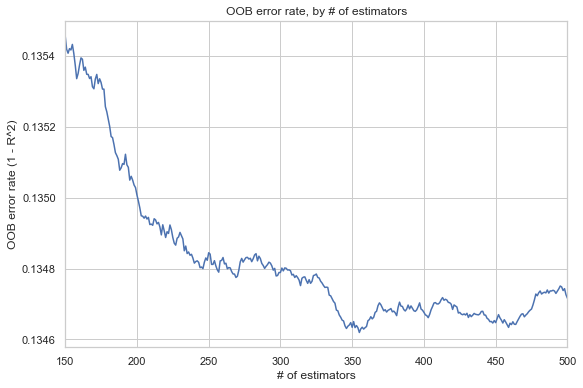

In [28]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
xs = []
ys = []
for label, clf_err in error_rate.items():
    xs.append(label)
    ys.append(clf_err)   

# plotting
fig, ax = plt.subplots(1, 1, figsize = (9, 6))    
sns.lineplot(x=xs,y=ys,ax=ax)
ax.set(xlabel='# of estimators',ylabel='OOB error rate (1 - R^2)',title='OOB error rate, by # of estimators')
plt.xlim(min_estimators, max_estimators)
plt.show()

In [160]:
## Not worth running as min_sample_leaf = 1 always beat the other
## then, min_sample_leaf
#ensemble_clfs = [
#    (1,
#     RandomForestRegressor(warm_start=True, 
#                           min_samples_leaf=1,
#                           oob_score=True,
#                           max_depth = 10,
#                           random_state=0)),
#    (5,
#     RandomForestClassifier(warm_start=True, 
#                            min_samples_leaf=5,
#                            oob_score=True,
#                            max_depth = 10,
#                            random_state=0))
#]
#
## Map a label (the value of `min_samples_leaf`) to a list of (model, oob error) tuples.
#error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)
#
#min_estimators = 150
#max_estimators = 500
#
#for label, clf in ensemble_clfs:
#    for i in range(min_estimators, max_estimators + 1):
#        clf.set_params(n_estimators=i) 
#        clf.fit(x_tr, y_tr)
#
#        # Record the OOB error for each model. Error is 1 - oob_score
#        # oob_score: score of the training dataset obtained using an 
#        # out-of-bag estimate.
#        oob_error = 1 - clf.oob_score_
#        error_rate[label].append((i, oob_error))

C:\Users\ryuic\Anaconda3\envs\cs109a\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\ryuic\Anaconda3\envs\cs109a\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


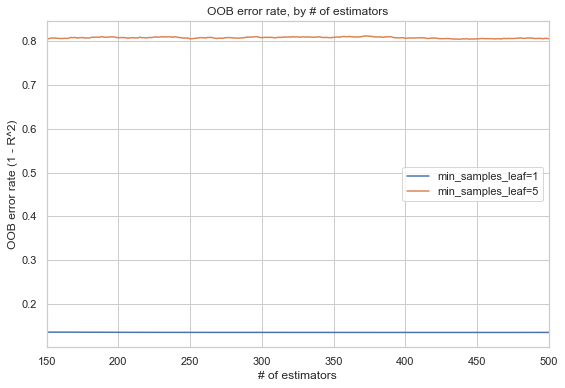

In [162]:
## plotting
#fig, ax = plt.subplots(1, 1, figsize = (9, 6))    
#for label, clf_err in error_rate.items():
#    xs, ys = zip(*clf_err)
#    sns.lineplot(xs, ys, label=f'min_samples_leaf={label}', ax=ax)
#ax.set(xlabel='# of estimators',ylabel='OOB error rate (1 - R^2)',title='OOB error rate, by # of estimators')
#plt.xlim(min_estimators, max_estimators)
#plt.show()    

In [163]:
#err = 100
#best_num_estimators = 0
#for label, clf_err in error_rate.items():
#    num_estimators, error = min(clf_err, key=lambda n: (n[1], -n[0]))
#    if error<err: err=error; best_num_estimators = num_estimators; best_leaf = label
#
#print(f'Optimum num of estimators: {best_num_estimators} \nmin_samples_leaf: {best_leaf}')

Optimum num of estimators: 355 
min_samples_leaf: 1


In [29]:
# simple Random Forest regression
rf_best = RandomForestRegressor(max_depth=10, n_estimators=355, random_state=0)
rf_best.fit(x_tr, y_tr)

rf_best_tr_pred = rf_best.predict(x_tr)
rf_best_te_pred = rf_best.predict(x_te)

rf_best_mse_tr = mean_squared_error(y_tr, rf_best_tr_pred)
rf_best_mse_te = mean_squared_error(y_te, rf_best_te_pred)
print(rf_best_mse_tr, rf_best_mse_te)

2.8480403907677534 5.435573925807826


## Random Forest regression (m=p/3)

In [30]:
# simple Random Forest regression
rf_mf = RandomForestRegressor(max_depth=10, max_features=int(x_tr.shape[1]/3), random_state=0)
rf_mf.fit(x_tr, y_tr)

rf_mf_tr_pred = rf_mf.predict(x_tr)
rf_mf_te_pred = rf_mf.predict(x_te)

rf_mf_mse_tr = mean_squared_error(y_tr, rf_mf_tr_pred)
rf_mf_mse_te = mean_squared_error(y_te, rf_mf_te_pred)
print(rf_mf_mse_tr, rf_mf_mse_te)

2.9641749979596868 5.570247198189145


In [31]:
# tuning hyper parameters
# start with n_estimators
clf = RandomForestRegressor(warm_start=True,oob_score=True,max_depth = 10,max_features=int(x_tr.shape[1]/3),random_state=0)

error_rate = {}

# Range of `n_estimators` values to explore.
min_estimators = 150
max_estimators = 500

for i in range(min_estimators, max_estimators + 1):
    clf.set_params(n_estimators=i) 
    clf.fit(x_tr, y_tr)

    # Record the OOB error for each `n_estimators=i` setting.
    oob_error = 1 - clf.oob_score_
    error_rate[i] = oob_error

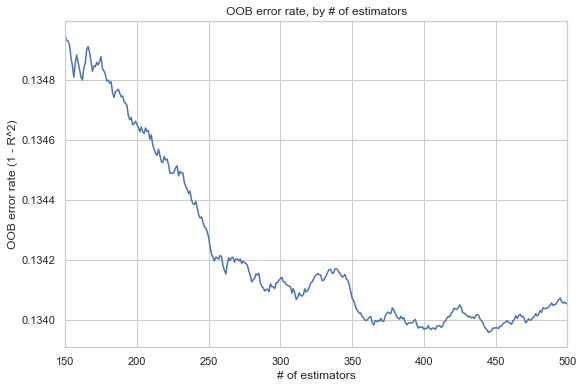

In [32]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
xs = []
ys = []
for label, clf_err in error_rate.items():
    xs.append(label)
    ys.append(clf_err)   

# plotting
fig, ax = plt.subplots(1, 1, figsize = (9, 6))    
sns.lineplot(x=xs,y=ys,ax=ax)
ax.set(xlabel='# of estimators',ylabel='OOB error rate (1 - R^2)',title='OOB error rate, by # of estimators')
plt.xlim(min_estimators, max_estimators)
plt.show()

In [33]:
# simple Random Forest regression
# set n_estimators at 400
rf_mf = RandomForestRegressor(max_depth=10, max_features=int(x_tr.shape[1]/3), n_estimators=400, random_state=0)
rf_mf.fit(x_tr, y_tr)

rf_mf_tr_pred = rf_mf.predict(x_tr)
rf_mf_te_pred = rf_mf.predict(x_te)

rf_mf_mse_tr = mean_squared_error(y_tr, rf_mf_tr_pred)
rf_mf_mse_te = mean_squared_error(y_te, rf_mf_te_pred)
print(rf_mf_mse_tr, rf_mf_mse_te)

2.94956734882587 5.6553288311082905


## Out of the box XGBoost

In [36]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
# create validation set
x_tr, x_val, y_tr, y_val = train_test_split(x_tr, y_tr, train_size=0.7, random_state=81)

In [37]:
dtrain = xgb.DMatrix(x_tr, label=y_tr)
dvalid = xgb.DMatrix(x_val, label=y_val)
dtest = xgb.DMatrix(x_te)

In [234]:
params = {'objective': 'reg:squarederror', 
          'booster': 'gbtree',
          'eta': 0.4,
          'gamma': 0.0,
          'alpha': 0.0,
          'lambda': 1.0,
          'min_chid_weight': 1,
          'max_depth': 5,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'random_state': 81
          }
num_round = 39

In [235]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
model = xgb.train(params, dtrain, num_round, evals=watchlist)

[10:59:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { min_chid_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:40.88293	eval-rmse:40.91401
[1]	train-rmse:24.66052	eval-rmse:24.69845
[2]	train-rmse:14.94460	eval-rmse:14.98957
[3]	train-rmse:9.16985	eval-rmse:9.22357
[4]	train-rmse:5.80507	eval-rmse:5.87526
[5]	train-rmse:3.92382	eval-rmse:4.00179
[6]	train-rmse:2.94956	eval-rmse:3.05027
[7]	train-rmse:2.48450	eval-rmse:2.61031
[8]	train-rmse:2.28415	eval-rmse:2.42441
[9]	train-rmse:2.19210	eval-rmse:2.34796
[10]	train-rmse:2.14741	eval-rmse:2.32163
[11]	train-rmse:2.12104	eval-rmse:2.30747
[12]	train-rmse:2.09230	eval-rmse:2.30772
[13]	train-rmse:2.07971	eval-rmse:2.30272
[14]	train-rmse:2.05703

In [236]:
va_pred = model.predict(dvalid)
te_pred = model.predict(dtest)

val_score = mean_squared_error(y_val, va_pred)
test_score = mean_squared_error(y_te, te_pred)

print(f'Validation MSE: {val_score:.3f}, test MSE: {test_score:3f}.')

Validation MSE: 5.433, test MSE: 5.854502.
